# Analysis of FSL, FF, and Metallcity in Nearby Galaxies
Based on "analysis_nii_ff_bration.py" from 2015 and updated July 2017

## Setup Workbook

In [2]:
%matplotlib inline
import os.path
import numpy as np
import numpy.ma as ma
import matplotlib.pylab as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table,join
from astropy import constants as const

import matplotlib.patches as mpatches
from astropy.cosmology import WMAP9
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import matplotlib.patheffects as PathEffects
from astropy import constants
from matplotlib.patches import Rectangle
from matplotlib import colors
import astro_tools as at

In [3]:
#Define a cosmology
cosmoWMAP=WMAP9
cosmoFLAT=FlatLambdaCDM(H0=70,Om0=0.3)

In [4]:
#define working directories
home = os.path.expanduser("~")
science_folder = os.path.join(home,'Dropbox','Research','Science')
active_folder = os.path.join(science_folder,'ff_fir_metalicity')
outfolder = os.path.join(active_folder,'outputs/')

In [5]:
#load the data on the local galaxies
oiii_nii_ff_metal_location=os.path.join(active_folder,'oiii_nii_ff_metallicity.csv')
#L_FIR is lensing corrected for lensed galaxies
data_table = ascii.read(oiii_nii_ff_metal_location,data_start=2)
for column in data_table.columns[2,3,5,6,8,9,11,12,14,15,17,18,20,21]:
    data_table['%s' %column].unit = '1e-18 W m^-2'
for column in data_table.columns[24,25]:
    data_table['%s' %column].unit='12+log(O/H)'
for column in data_table.columns[27,28,32,33]:
    data_table['%s' %column].unit='mJy'
for column in data_table.columns[30,34]:
    data_table['%s' %column].unit='GHz'
data_table.columns[30,34].unit = 'GHz'
data_table.columns[37].unit = 'Mpc'

In [6]:
#Scientifically Useful Constants:
ff_fraction = 0.3 #The faction of the 5GHz Continuum that is attributable to free-free emission for star forming systems


def thermal_fraction(freq1,alpha):
    freq2= 1.7 #GHz
    alpha_nt=0.85 #murphy 2012
    alpha_ff=0.1
    upper = ((freq2/freq1)**-alpha-(freq2/freq1)**-alpha_nt)
    lower = ((freq2/freq1)**-alpha_ff-(freq2/freq1)**-alpha_nt)
    return upper/lower
    


In [7]:
thermal_fraction(5,.9)

-0.09990504469336861

## Calculate the expected ratios of FSL/FF

In [8]:

def free_free_specific_lum(frequency,temperature,gaunt_ff,electron_den,volume): 
    ''' from Rybicki and Lightman 1985, assuminges hydrogen,i.e. charge_num, Z, is 1 and electron_den = ion_density
        temperature must be in kelvin, freuquency in hertz, electron_den in cm^-3, and volume in cm^3
        will return the luminosity in ergs/s/Hz
    '''
    specific_lum = 6.8e-38*electron_den**2*temperature**(-0.5)*np.exp(-const.h.value*frequency/(const.k_B.value*temperature))
    return specific_lum

def fsl_luminosity_lowDen(frequency,electron_den,ion_fraction,abundance,collision_rate,volume):
    ''' 
        freuquency in hertz, ion fraction and abundnace as a decimal fraction, electron_den in cm^-3,
        collisional rate coefficient in cm^3/s and volume in cm^3
        will return the luminosity in J/s
    '''
    line_luminosity = const.h.to("erg s").value*frequency*electron_den**2*ion_fraction*abundance*collision_rate*volume
    return line_luminosity

def collision_rate_coeff(temperature,stat_weight,collision_strength,frequency):
    '''See Osterbrock & Ferland 2006
        temperature in kelvin, freuquency in hertz, 
        returns collisional rate coefficient in cm^3/s 
    '''
    collision_rate = 8.6e-6/temperature**(0.5)*collision_strength/stat_weight*np.exp(const.h.value*frequency/(const.k_B.value*temperature))
    return collision_rate
    
line_frequencies = np.array([at.FSL_line_frequency('[NII] 122'),at.FSL_line_frequency('[OIII] 88'),
                             at.FSL_line_frequency('[CII] 158')])*10**9

radio_frequency = 5e9 #Hertz

gaunt_ff_5Ghz = 4.86 

temperature = 8000 #Kelvin

volume = 1 #as long as it is the same then it is OK

electron_den = 1 #as long as it is the same then it is OK

collision_strengths_weights =np.array([('[NII] 122',0.25, 1), #from 3P0 to 3P2, the state weight for lower level, Hudson & Bell 2004
                                       ('[OIII] 88',0.55, 1), #from 3P0 to #3P1, the state weight for lower level
                                       ('[CII] 158',2.15, 2)], #from 1P1/2 to 1P3/2, the state weight for lower level
                                        dtype={'names'   :["Line","collision_strength", 'stat_weight'],
                                               'formats' :['|S10',       'float64',      'float64']})

nii_q=collision_rate_coeff(8000.,collision_strengths_weights['stat_weight'][0],collision_strengths_weights["collision_strength"][0],line_frequencies[0])
oiii_q=collision_rate_coeff(8000.,collision_strengths_weights['stat_weight'][1],collision_strengths_weights["collision_strength"][1],line_frequencies[1])
cii_q=collision_rate_coeff(8000.,collision_strengths_weights['stat_weight'][2],collision_strengths_weights["collision_strength"][2],line_frequencies[2])

collision_rates =np.array([('[NII] 122', nii_q, 'cm^3/s'),
                           ('[OIII] 88', oiii_q, 'cm^3/s') ,
                           ('[CII] 158', cii_q, 'cm^3/s')],
                          dtype={'names'   :["Line","collision_rate","rate_unit"],
                                 'formats':['|S10',       'float64',     '|S10']})
                          
def nii_ff_metallicity(o_h_ratio,ion_fraction,o_n_ratio):
    fsl = fsl_luminosity_lowDen(line_frequencies[0],1,ion_fraction,o_h_ratio/o_n_ratio,collision_rates["collision_rate"][0],1)
    ff = free_free_specific_lum(radio_frequency,8000,gaunt_ff_5Ghz,1,1)
    return fsl/ff

def oiii_ff_metallicity(o_h_ratio,ion_fraction,o_o_ratio):
    fsl = fsl_luminosity_lowDen(line_frequencies[1],1,ion_fraction,o_h_ratio/o_o_ratio,collision_rates["collision_rate"][1],1)
    ff = free_free_specific_lum(radio_frequency,8000,gaunt_ff_5Ghz,1,1)
    return fsl/ff

def cii_ff_metallicity(o_h_ratio,ion_fraction,o_c_ratio):
    fsl = fsl_luminosity_lowDen(line_frequencies[2],1,ion_fraction,o_h_ratio/o_c_ratio,collision_rates["collision_rate"][2],1)
    ff = free_free_specific_lum(radio_frequency,8000,gaunt_ff_5Ghz,1,1)
    return fsl/ff

In [9]:
fsl_luminosity_lowDen(line_frequencies[0],1,1,1,collision_rates["collision_rate"][0],1)

3.9754168438057769e-22

In [10]:
(6.8e-38*8000**-0.5*4.86)

3.694878726020653e-39

In [11]:
free_free_specific_lum(radio_frequency,8000,gaunt_ff_5Ghz,1,1)

7.6024030839390413e-40

In [12]:
fsl_luminosity_lowDen(line_frequencies[0],1,1,1,collision_rates["collision_rate"][0],1)/(6.8e-38*1**2*8000**(-0.5)*np.exp(-const.h.value*5e9/(const.k_B.value*8000)))

5.2291582015748499e+17

In [13]:
gaunt_ff_5Ghz

4.86

In [38]:
nii_ff_metallicity(1.,1.,1.)*.1*.13/10**15


6.797905662047306

In [15]:
oiii_ff_metallicity(1.,1.,1.)*.1*1

1.5960478010875648e+17

In [17]:
cii_ff_metallicity(1.,1.,1.)*.1*.67

1.1602984317186376e+17

In [21]:
#savage & semback 1996 HII nebular abundances
n_h = 7.76E-05
o_h = 5.89E-04
c_h = 3.98E-04
o_n_ratio = o_h/n_h
o_o_ratio = 1
o_c_ratio = o_h/c_h
nii_fraction = 0.1
oiii_fraction = 0.1
cii_fraction = 0.1

In [22]:
1/o_n_ratio

0.13174872665534806

In [23]:
1/o_c_ratio

0.6757215619694398

## Define Some Utility Functions

In [24]:
def make_masked_quantities(data_table,convert_unit=False,desired_unit=None):
    #print unit
    if convert_unit == False:
        values = (data_table.data.data.astype(np.float)*data_table.unit)
    else:
        values = (data_table.data.data.astype(np.float)*data_table.unit).to(desired_unit)
    mask = ma.copy(data_table.mask)
    return ma.array(values,mask=mask)

def linear_to_log_errors(data_table,linear_errors):
    upper_bound = data_table+linear_errors
    lower_bound = data_table-linear_errors
    log_data = np.log10(data_table)
    log_upper_bound = np.log10(upper_bound)
    log_lower_bound = np.log10(lower_bound)
    positive_error = log_upper_bound-log_data
    negative_error = log_data-log_lower_bound
    return positive_error,negative_error

def linear_to_log_errors_log_data(log_data_table,linear_errors):
    upper_bound = 10**log_data_table+linear_errors
    lower_bound = 10**log_data_table-linear_errors
    log_data = log_data_table
    log_upper_bound = np.log10(upper_bound)
    log_lower_bound = np.log10(lower_bound)
    positive_error = log_upper_bound-log_data
    negative_error = log_data-log_lower_bound
    return positive_error,negative_error

## Define plotting variables

In [25]:
#cii = make_masked_quantities(data_table['CII'],True,'W m^-2')
cii_data = make_masked_quantities(data_table['CII'],True,'W m^-2')
ERRcii = make_masked_quantities(data_table['errCII'],True,'W m^-2')
ULcii = np.zeros(len(cii_data))
ULcii[np.where(data_table['ulCII']==1)[0]]=True

#nii = make_masked_quantities(data_table['N122'],True,'W m^-2')
nii_data = make_masked_quantities(data_table['N122'],True,'W m^-2')
ERRnii = make_masked_quantities(data_table['errN122'],True,'W m^-2')
ULnii = np.zeros(len(nii_data))
ULnii[np.where(data_table['ulN122']==1)[0]]=True

#oiii= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
oiii_data= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
ERRoiii = make_masked_quantities(data_table['errOIII88'],True,'W m^-2')
ULoiii = np.zeros(len(oiii_data))
ULoiii[np.where(data_table['ulOIII88']==1)[0]]=True

ff  = make_masked_quantities(data_table['FreeFree'])*ff_fraction
ERRff = make_masked_quantities(data_table['errFreeFree'])*ff_fraction
#For Free Free values without an uncertainty I assume an error 30% (i.e they are ~3 sigma detections)
ERRff[np.where(data_table['errFreeFree'].data.data==0.)[0]]=0.3*ff[np.where(data_table['errFreeFree'].data.data==0.)[0]].data*ff_fraction
ULff = np.zeros(len(ff))
ULff[np.where(data_table['ulFreeFree']==1)[0]]=True

metallicity = ma.array(np.copy(data_table['Metallicity'].data.data),mask=ma.copy(data_table['Metallicity'].data.mask))
ERRmetallicity = data_table['errMetallicity'].data.data
#For the metallicity values without a given uncertainty I give a 0.1 dex error
ERRmetallicity[np.where(data_table['errMetallicity'].data.data<0.1)[0]]=0.1


## Plot Data -- Line, FF, Metallicity -- Individual Plots

The code below makes plots of NII/FF, OIII/FF and CII/FF of the local galaxies. The points are color coded by the OIII/NII ratio. The free-free values are taken to be the 5GHz radio continuum assuming that the free-free is 30% at that point. Also plotted are the expected. C,N to O ratios are taken from Savage & Sembach b. The NII, CII and OIII ionization fractions are all assumed to be 0.1

C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: RuntimeWarning: divide by zero encountered in log10


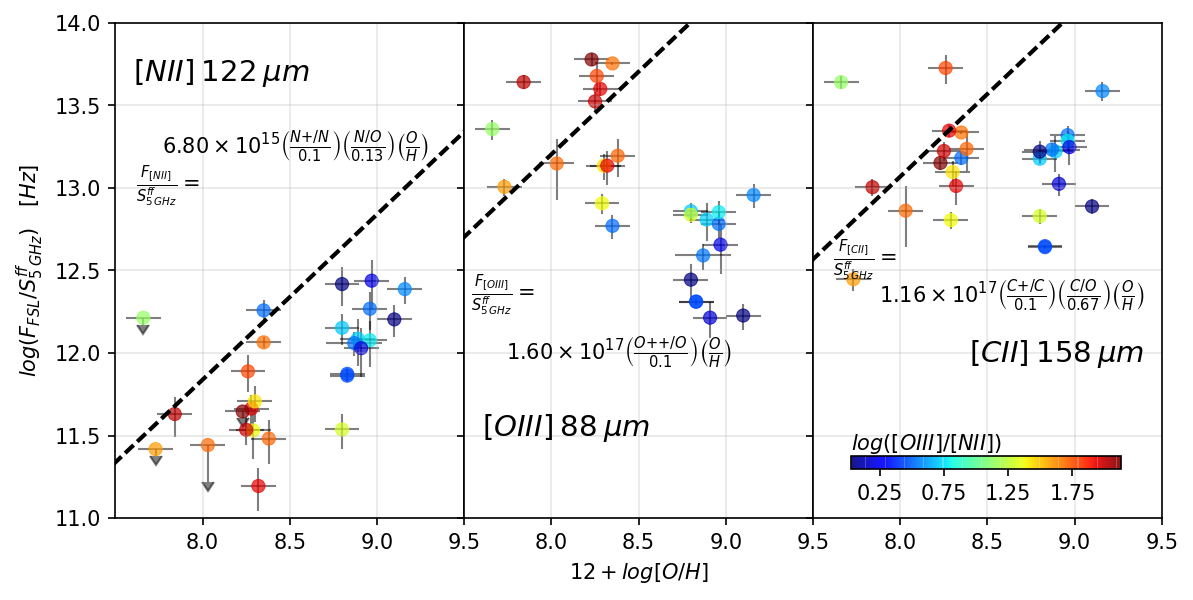

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9,4.375),dpi=150)
fig.subplots_adjust(wspace=0.001)

logOH_12_range = np.arange(7.0,10,.1)
linearOH = 10**(logOH_12_range-12)

#----------------NII/FF versus Metalicity ------------------------------------#
axes[0].set_ylabel(r'$log(F_{FSL}/S_{5\: GHz}^{ff})\quad  [Hz]$')
#axes[0].set_ylabel(r'$log(F_{FSL}/S_{\nu}^{radio})$')
#axes[0].set_xlabel(r'$12+log[O/H]$')


ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

#cmap = plt.cm.jet
#norm = colors.Normalize(zdata.min(),zdata.max())
#ec_colors = plt.cm.jet(norm(zdata))


yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_log_pos[where_UL]=0

yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
xerr = ERRmetallicity

axes[0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)



axes[0].plot(logOH_12_range,np.log10(nii_ff_metallicity(linearOH,nii_fraction,o_n_ratio)),color='black',linewidth=2,linestyle='--')
axes[0].annotate(r'$\frac{F_{[NII]}}{S_{5\: GHz}^{ff}} = $',
                 (.24,.67), xycoords='axes fraction', ha='right',va='center',fontsize=10)
axes[0].annotate(r'$6.80\times10^{15}\left( \frac{N{+}/N}{0.1} \right) \left( \frac{N/O}{0.13} \right) \left( \frac{O}{H} \right)$',
                 (.9,.75), xycoords='axes fraction', ha='right',va='center',fontsize=10)

axes[0].annotate(r"$[NII]\: 122\: \mu m$",(.05,.9),xycoords='axes fraction', ha='left',va='center',fontsize=14)
#----------------OIII/FF versus Metalicity ------------------------------------#

#axes[1].set_ylabel(r'$log([OIII]/S_{\nu}^{radio})$')
axes[1].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((oiii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRoiii/oiii_data).data.value**2+(ERRff/ff).data.value**2)*(oiii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULoiii

xerr = ERRmetallicity

axes[1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)

axes[1].plot(logOH_12_range,np.log10(oiii_ff_metallicity(linearOH,oiii_fraction,o_o_ratio)),color='black',linewidth=2,linestyle='--')
axes[1].annotate(r'$\frac{F_{[OIII]}}{S_{5\: GHz}^{ff}} = $',
                 (.02,.45), xycoords='axes fraction', ha='left',va='center',fontsize=10)
axes[1].annotate(r'$1.60\times10^{17}\left( \frac{O{+}{+}/O}{0.1} \right) \left( \frac{O}{H} \right)$',
                 (.12,.3), xycoords='axes fraction', ha='left',va='bottom',fontsize=10)
axes[1].annotate(r"$[OIII]\: 88\: \mu m$",(.05,.15),xycoords='axes fraction', ha='left',va='bottom',fontsize=14)

#----------------CII/FF versus Metalicity ------------------------------------#
#axes[2].set_ylabel(r'$log([CII]/S_{\nu}^{radio})$')
#axes[2].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[2].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[2].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             
axes[2].plot(logOH_12_range,np.log10(cii_ff_metallicity(linearOH,cii_fraction,o_c_ratio)),color='black',linewidth=2,linestyle='--')
axes[2].annotate(r'$\frac{F_{[CII]}}{S_{5\: GHz}^{ff}} = $',
                 (.24,.52), xycoords='axes fraction', ha='right',va='center',fontsize=10)
axes[2].annotate(r'$1.16\times10^{17}\left( \frac{C{+}/C}{0.1} \right) \left( \frac{C/O}{0.67} \right) \left( \frac{O}{H} \right)$',
                 (.95,.45), xycoords='axes fraction', ha='right',va='center',fontsize=10)

axes[2].annotate(r"$[CII]\: 158\: \mu m$",(.95,.3),xycoords='axes fraction', ha='right',va='bottom',fontsize=14)

#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.67,0.2,0.2,0.02])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$log([OIII]/[NII])$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')

xticklabels = axes[1].get_yticklabels() + axes[2].get_yticklabels()
plt.setp(xticklabels, visible=False)

for ax in axes.flat:
    ax.set_ylim([11.0,14.0])
    ax.set_xlim([7.5,9.5])
    ax.set_yticks([11,11.5,12.0,12.5,13.0,13.5,14])
    ax.set_xticks([8.0,8.5,9.0,9.5])
    ax.grid(True,alpha=0.3)
    


In [36]:
fig.savefig(os.path.join(outfolder,'png','nii_oii_cii_ff_OH_relation.png'),dpi=300,bbox_inches='tight',pad_inches=0.5)
fig.savefig(os.path.join(outfolder,'pdf','nii_oii_cii_ff_OH_relation.pdf'),dpi=300,bbox_inches='tight',pad_inches=0.5)


## Plot Data -- Line, FF, Metallicity -- Individual Plots (cloudy abundances)

The code below makes plots of NII/FF, OIII/FF and CII/FF of the local galaxies. The points are color coded by the OIII/NII ratio. The free-free values are taken to be the 5GHz radio continuum assuming that the free-free is 30% at that point. Also plotted are the expected. N to O ratios are taken from CLOUDY while C to O is from SAVAGE & SEMBACH

In [291]:
cloudy_o_solar_abundance = 8.69
cloudy_n_solar_abundance = 7.93
#abundance = metallicity - cloudy_o_solar_abundance
abundance_data = metallicity - cloudy_o_solar_abundance
cloudy_o_n_ratio = 10**(cloudy_o_solar_abundance-12)/10**(cloudy_n_solar_abundance-12)



C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: divide by zero encountered in log10


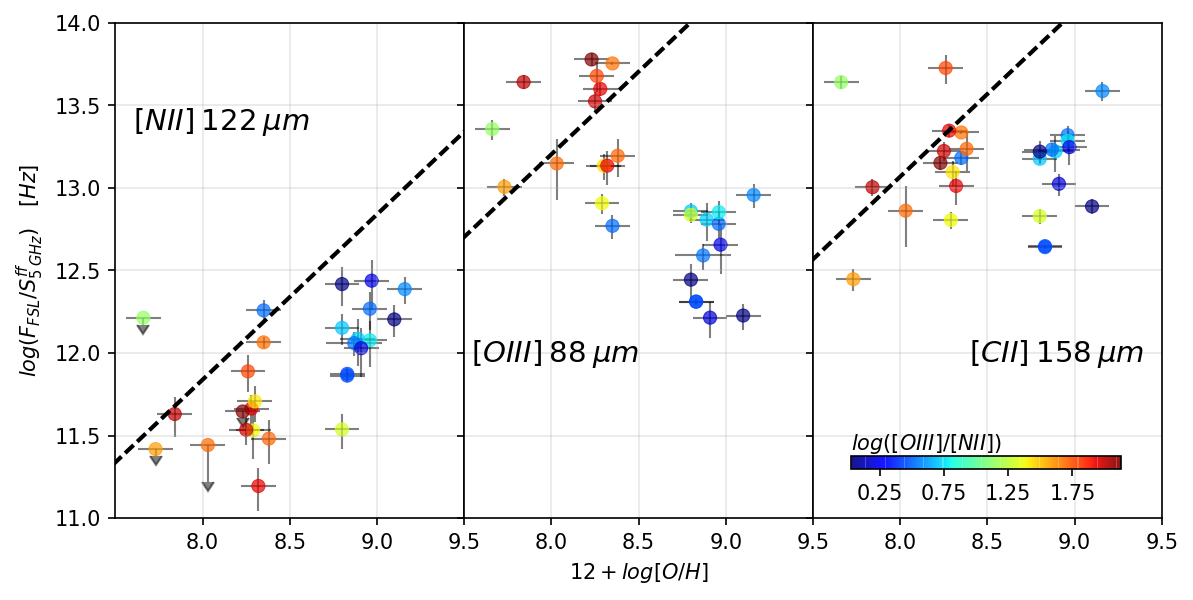

In [32]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(9,4.375),dpi=150)
fig.subplots_adjust(wspace=0.001)

logOH_12_range = np.arange(7.0,10,.1)
linearOH = 10**(logOH_12_range-12)

#----------------NII/FF versus Metalicity ------------------------------------#
axes[0].set_ylabel(r'$log(F_{FSL}/S_{5\: GHz}^{ff})\quad  [Hz]$')
#axes[0].set_ylabel(r'$log(F_{FSL}/S_{\nu}^{radio})$')
#axes[0].set_xlabel(r'$12+log[O/H]$')


ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

#cmap = plt.cm.jet
#norm = colors.Normalize(zdata.min(),zdata.max())
#ec_colors = plt.cm.jet(norm(zdata))


yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_log_pos[where_UL]=0

yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
xerr = ERRmetallicity

axes[0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)



axes[0].plot(logOH_12_range,np.log10(nii_ff_metallicity(linearOH,nii_fraction,o_n_ratio)),color='black',linewidth=2,linestyle='--')


axes[0].annotate(r"$[NII]\: 122\: \mu m$",(.05,.8),xycoords='axes fraction', ha='left',va='center',fontsize=14)
#----------------OIII/FF versus Metalicity ------------------------------------#

#axes[1].set_ylabel(r'$log([OIII]/S_{\nu}^{radio})$')
axes[1].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((oiii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRoiii/oiii_data).data.value**2+(ERRff/ff).data.value**2)*(oiii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULoiii

xerr = ERRmetallicity

axes[1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)

axes[1].plot(logOH_12_range,np.log10(oiii_ff_metallicity(linearOH,oiii_fraction,o_o_ratio)),color='black',linewidth=2,linestyle='--')
             
axes[1].annotate(r"$[OIII]\: 88\: \mu m$",(.5,.3),xycoords='axes fraction', ha='right',va='bottom',fontsize=14)

#----------------CII/FF versus Metalicity ------------------------------------#
#axes[2].set_ylabel(r'$log([CII]/S_{\nu}^{radio})$')
#axes[2].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[2].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[2].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             
axes[2].plot(logOH_12_range,np.log10(cii_ff_metallicity(linearOH,cii_fraction,o_c_ratio)),color='black',linewidth=2,linestyle='--')


axes[2].annotate(r"$[CII]\: 158\: \mu m$",(.95,.3),xycoords='axes fraction', ha='right',va='bottom',fontsize=14)

#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.67,0.2,0.2,0.02])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$log([OIII]/[NII])$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')

xticklabels = axes[1].get_yticklabels() + axes[2].get_yticklabels()
plt.setp(xticklabels, visible=False)

for ax in axes.flat:
    ax.set_ylim([11.0,14.0])
    ax.set_xlim([7.5,9.5])
    ax.set_yticks([11,11.5,12.0,12.5,13.0,13.5,14])
    ax.set_xticks([8.0,8.5,9.0,9.5])
    ax.grid(True,alpha=0.3)
    


In [33]:
fig.savefig(os.path.join(outfolder,'png','nii_oii_cii_ff_OH_relation_noEqn.png'),dpi=300,bbox_inches='tight',pad_inches=0.5)
fig.savefig(os.path.join(outfolder,'pdf','nii_oii_cii_ff_OH_relation_noEqn.pdf'),dpi=300,bbox_inches='tight',pad_inches=0.5)

## Plot Data in a Square

C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\ma\core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: divide by zero encountered in log10
C:\Users\en3966ay\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: RuntimeWarning: divide by zero encountered in log10


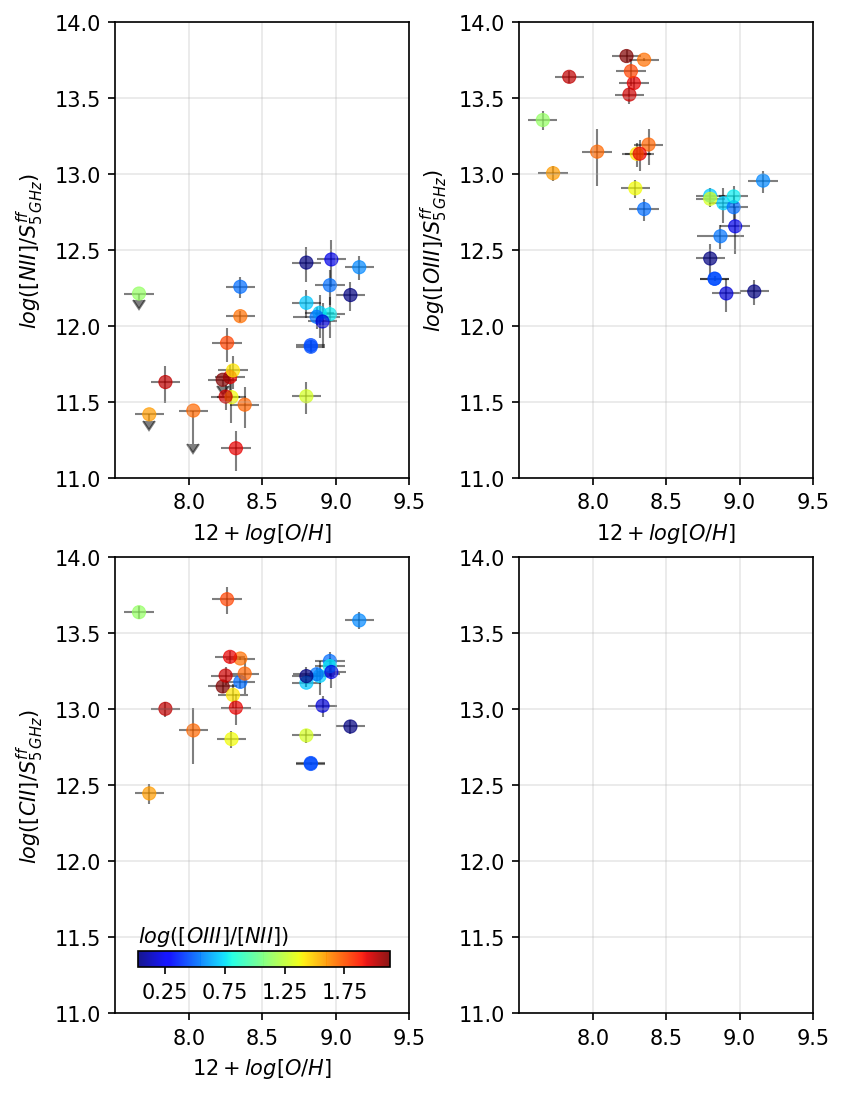

In [165]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,8.75),dpi=150)
fig.subplots_adjust(hspace=.175,wspace=.375)

#----------------NII/FF versus Metalicity ------------------------------------#
axes[0,0].set_ylabel(r'$log([NII]/S_{5\: GHz}^{ff})$')
axes[0,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

#cmap = plt.cm.jet
#norm = colors.Normalize(zdata.min(),zdata.max())
#ec_colors = plt.cm.jet(norm(zdata))


yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_log_pos[where_UL]=0

yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
xerr = ERRmetallicity

axes[0,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)


#----------------OIII/FF versus Metalicity ------------------------------------#

axes[0,1].set_ylabel(r'$log([OIII]/S_{5\: GHz}^{ff})$')
axes[0,1].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((oiii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRoiii/oiii_data).data.value**2+(ERRff/ff).data.value**2)*(oiii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULoiii

xerr = ERRmetallicity

axes[0,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             


#----------------CII/FF versus Metalicity ------------------------------------#
axes[1,0].set_ylabel(r'$log([CII]/S_{5\: GHz}^{ff})$')
axes[1,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[1,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[1,0].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             


#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.15,0.16,0.28,0.0125])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$log([OIII]/[NII])$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')

for ax in axes.flat:
    ax.set_ylim([11,14])
    ax.set_xlim([7.5,9.5])
    ax.set_yticks([11,11.5,12.0,12.5,13.0,13.5,14.0])
    ax.set_xticks([8.0,8.5,9.0,9.5])
    ax.grid(True,alpha=0.3)

### Save Figures

In [166]:
fig.savefig(os.path.join(outfolder,'png','nii_oii_cii_ff_OH_SQUARE.png'),dpi=300,bbox_inches='tight',pad_inches=0.4)
fig.savefig(os.path.join(outfolder,'pdf','nii_oii_cii_ff_OH_SQUARE.pdf'),dpi=300,bbox_inches='tight',pad_inches=0.3)
